# Churn Rate Prediction

In this notebook, we attempt to predict whether a customer will churn (or stop using the service) from a set of given features. The service analyzed is a free online investment platform and a user is defined to have churned if their account balance falls below 100\$ for 28 consecutive days. 

Data is provided as .csv files:

equity_history.csv -- Contains a User ID and the account balance history of the user (at daily incremenets) 

user_features.csv -- Contains user IDs and a list of features that may be useful for predicting customer churns.

In [57]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)

# For those using dark-themed jupyter notebooks, the following will change the matplotlib plotstyle to a dark theme. Requires jupyterthemes.
# Comment these lines if they are not needed.
from jupyterthemes import jtplot
plt.style.use('dark_background')
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

## Read in and Process Datasets

In [58]:
equity_value_data = pd.read_csv('equity_history.csv')#.iloc[:10000]
features_data = pd.read_csv('user_features.csv')#.iloc[:10000]
logging.info(f'Equity_value_data:')
logging.info(f'    equity_value_data shape: {equity_value_data.shape}')
logging.info(f'    equity_value_data columns: {equity_value_data.columns.values}')
logging.info(f'    equity_value_data NaNs: {equity_value_data.isna().sum().sum()}')
logging.info(f'features_data:')
logging.info(f'    features_data shape: {features_data.shape}')
logging.info(f'    features_data columns: {features_data.columns.values}')
logging.info(f'    features_data NaNs: {features_data.isna().sum().sum()}')
# It's somewhat unclear whether a customer should be considered churned if at *any* point in their account history their balance 
# falls below 100$ for 28 consecutive days (allowing the possibility for a churned customer to have redeposited a significant balance at 
# later date) or if such cases should not be considered churned, since the customer returned to the platform. Here, we classify these
# customers as *not* churned.
user_churn_group = equity_value_data.groupby('user_id')['timestamp', 'close_equity']
user_churn_labels = user_churn_group.apply(lambda user: (user.close_equity[-28:]<100).all()).rename('churned')
churn_rate = user_churn_labels.sum() / user_churn_labels.shape[0]
logging.info(f'Percentage Churned: {churn_rate * 100}%')
all_data_df = pd.merge(features_data, user_churn_labels, on='user_id')

2021-12-16 01:32:05,589 - Equity_value_data:
2021-12-16 01:32:05,589 -     equity_value_data shape: (1119158, 3)
2021-12-16 01:32:05,590 -     equity_value_data columns: ['timestamp' 'close_equity' 'user_id']
2021-12-16 01:32:05,646 -     equity_value_data NaNs: 0
2021-12-16 01:32:05,647 - features_data:
2021-12-16 01:32:05,647 -     features_data shape: (5584, 9)
2021-12-16 01:32:05,648 -     features_data columns: ['risk_tolerance' 'investment_experience' 'liquidity_needs' 'platform'
 'time_spent' 'instrument_type_first_traded' 'first_deposit_amount'
 'time_horizon' 'user_id']
2021-12-16 01:32:05,652 -     features_data NaNs: 0
2021-12-16 01:32:08,136 - Percentage Churned: 22.74355300859599%


We find our data to be relatively clean; i.e. no NaNs to worry about. Our dataset is large but is manageable in its current form. We see that 18% of customers are churned. This leads to somewhat imbalanced classes. Because the evaluation metric is accuracy, we could achieve nearly 82% accuracy by simply classifying all customers as not churned. This will be the baseline on which we try to improve.

## Data Exploration

We plot the features of the dataset to get a sense of their distribution and to look for any obvious patterns.

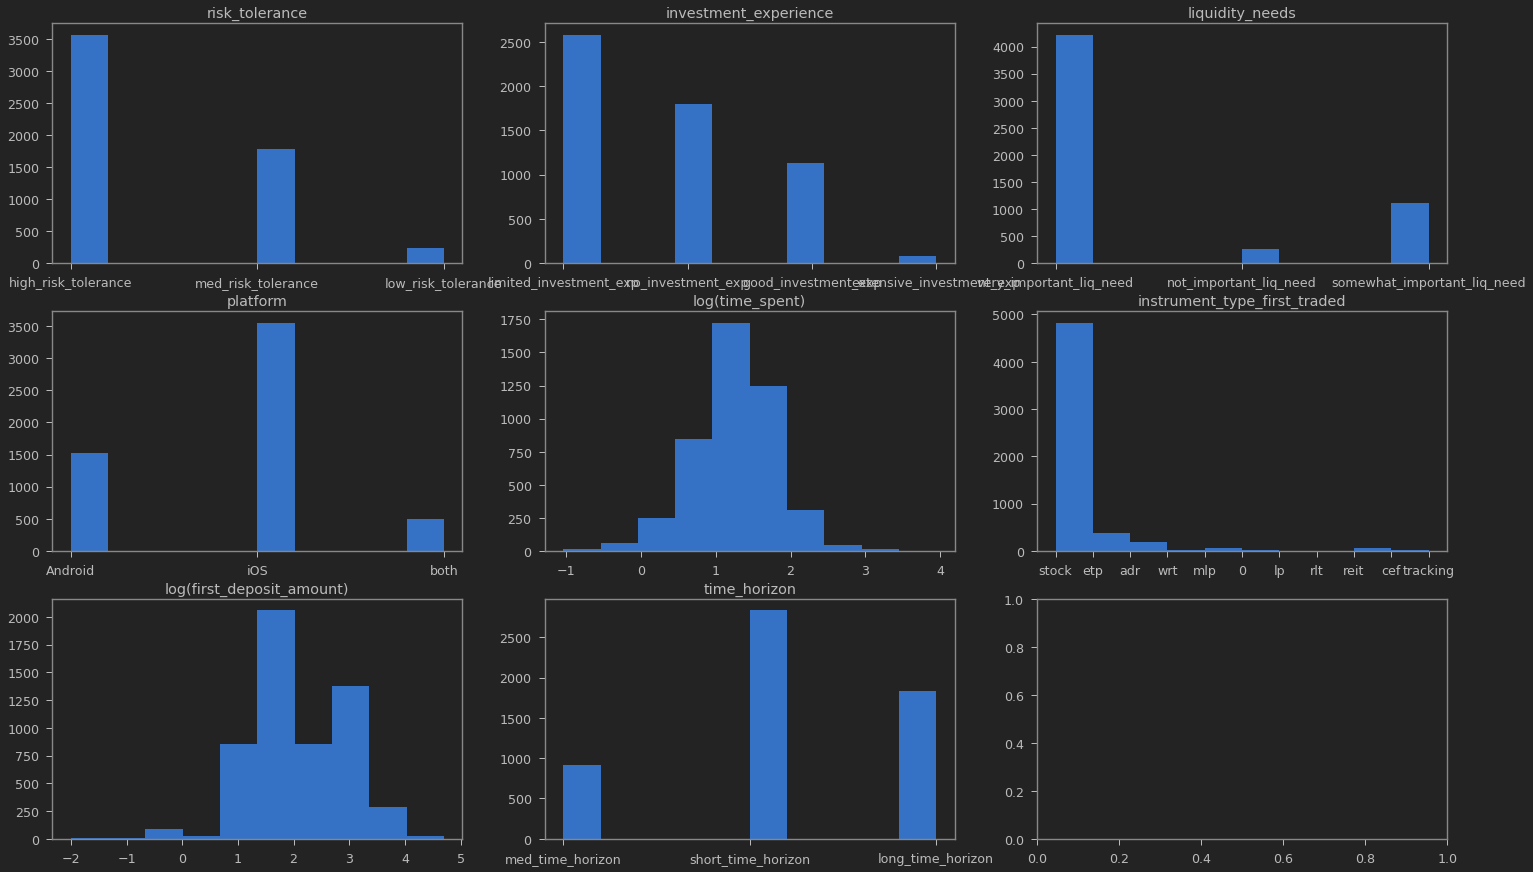

(array([1421.,  405.,  414.,  381.,  336.,  308.,  246.,  205.,  171.,
         143.]),
 array([ 0.        ,  2.99833833,  5.99667667,  8.995015  , 11.99335333,
        14.99169167, 17.99003   , 20.98836833, 23.98670667, 26.985045  ,
        29.98338333]),
 <BarContainer object of 10 artists>)

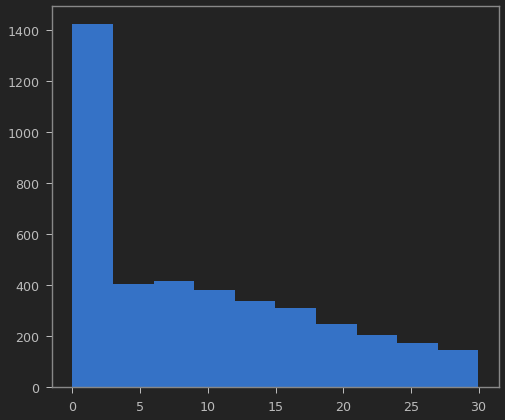

In [59]:
fig, ax = plt.subplots(3,3, figsize=(25,15))
for i in range(3):
    for j in range(3):
        if i == 2 and j==2:
            continue
        col = features_data.columns.values[3*i + j]
        if col == 'time_spent' or col =='first_deposit_amount':
            ax[i,j].hist(np.log10(features_data[col][features_data[col].astype(np.float32)>10**-6]).values)
            ax[i,j].set_title('log(' + col+')')
        else:
            ax[i,j].hist(features_data[col].values)
            ax[i,j].set_title(col)
plt.show()

plt.hist(features_data['time_spent'][features_data['time_spent']<30])

From viewing histograms of the dataset, we can take away that 6/8 features are categorical and 2/8 are continuous. The continuous features follow a (roughly) gaussian distribution when logarithmically scaled, but contain some outliers (0 time spent, 0$ first deposit) which must be removed for logarithmic scaling to be possible. Categorical variables will be 1 hot encoded when used as features.

In [60]:
logging.info(f'Num users with <= 0$ first deposit {all_data_df[all_data_df["first_deposit_amount"]==0].count()}')
logging.info(f'Num users with <= 0 time spent {all_data_df[all_data_df["time_spent"]==0].count()}')

2021-12-16 01:32:30,116 - Num users with <= 0$ first deposit risk_tolerance                  4
investment_experience           4
liquidity_needs                 4
platform                        4
time_spent                      4
instrument_type_first_traded    4
first_deposit_amount            4
time_horizon                    4
user_id                         4
churned                         4
dtype: int64
2021-12-16 01:32:30,120 - Num users with <= 0 time spent risk_tolerance                  1079
investment_experience           1079
liquidity_needs                 1079
platform                        1079
time_spent                      1079
instrument_type_first_traded    1079
first_deposit_amount            1079
time_horizon                    1079
user_id                         1079
churned                         1079
dtype: int64


It appears that there are 1079 users with 0 time spent on the platform. However, most of these users did make a first deposit, as only 4 users have a first deposit of zero. This leads me to believe that there were some missing entries for time spent on the platform. This may be a bug related to the platform of the user (perhaps the app does not accurately report data on one platform). The plot below shows that, while this is heavily correlated with iOS devices, it is present for all 3 platforms. I will handle this by simply adding an $\epsilon$ to all 0 values for time spent.

Text(0.5, 1.0, 'Bugged time_spent Entries')

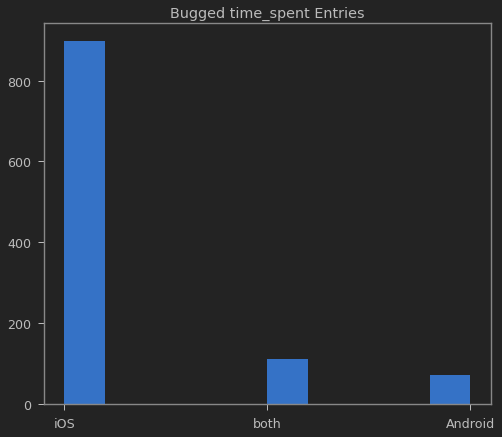

In [61]:
plt.hist(all_data_df[all_data_df["time_spent"]==0]['platform'].values)
plt.title('Bugged time_spent Entries')

We remake the plots above, plotting churned and unchurned users in different colors and weighting samples to allow for direct comparison (the weight factors cause the churned users to have equal contribution to the histogram as not churned users).

/home/kwl/.pyenv/versions/3.6.8/envs/torch-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


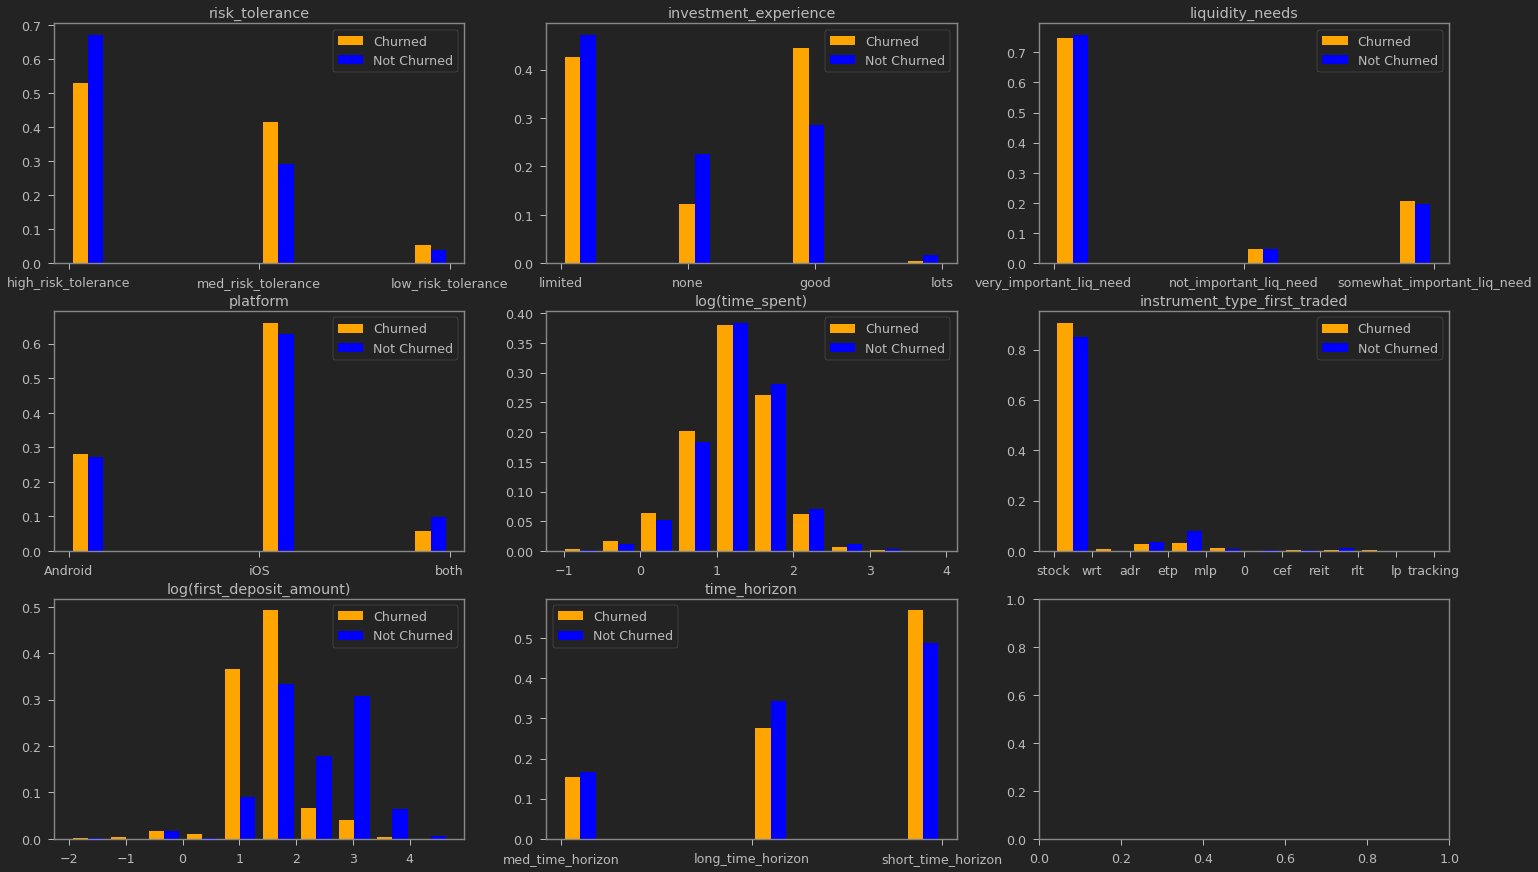

In [62]:
fig, ax = plt.subplots(3,3, figsize=(25,15))
for i in range(3):
    for j in range(3):
        if i == 2 and j>=2:
            continue
        col = features_data.columns.values[3*i + j]
        if col == 'time_spent' or col =='first_deposit_amount':
            data = features_data[col][features_data[col].astype(np.float32)>10**-6]
            churned_data = np.log10(data[all_data_df['churned']])
            not_churned_data = np.log10(data[~all_data_df['churned']])
            weights=[np.ones_like(churned_data)/len(churned_data), np.ones_like(not_churned_data)/len(not_churned_data)]
            ax[i,j].hist([churned_data, not_churned_data], color=['orange', 'blue'], weights=weights)
            ax[i,j].set_title('log(' + col+')')
        else:
            data = features_data[col]
            churned_data = data[all_data_df['churned']]
            not_churned_data = data[~all_data_df['churned']]
            weights=[np.ones_like(churned_data)/len(churned_data), np.ones_like(not_churned_data)/len(not_churned_data)]
            ax[i,j].hist([churned_data, not_churned_data], color=['orange', 'blue'], weights=weights)
            ax[i,j].set_title(col)
        if i==0 and j==1:
            ax[i,j].set_xticklabels(['limited', 'none', 'good', 'lots'])
        ax[i,j].legend(['Churned', 'Not Churned'])
plt.show()

Interestingly, it seems like the best predictor is the first_deposit_amount. Those with a small first deposit amount (0-100$) seem to churn significantly more than those with a large first deposit amount. This makes sense, as these users would be considered churned if they do not make additional deposits beyond their initial deposit. It seems that the definition of a "churned" user may be better defined as a user that, at one point had an equity above 100, but then left the platform (equity < 100 for 28 consecutive days), but I will press on with the given definition.

Users with no investment experience are more likely to churn. This is also easily understood; users new to investing may find themselves not interested more often than those that already have investment experience and are downloading an investment platform.

Interestingly, high risk tolerance is correlated with a decreased churn rate. This is a bit more difficult to understand, as those with high risk tolerance forseeably could drain their account equity much quicker than users with low risk tolerance. Perhaps it is due to the platforms reputation and support for executing risky investments; i.e. product fit is better for users with high risk tolerance.

## Data Formatting

We format the data for input into a machine learning model. Categorical features are one hot encoded. Continuous features are normalized.

In [63]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

epsilon = 10 ** -2
all_data_df['time_spent'] += epsilon 
all_data_df['first_deposit_amount'] += epsilon 
features = pd.DataFrame(all_data_df['user_id'])
# Remove users with 0$ initial deposit or 0 time spent.
for col in all_data_df.columns.values:
    if col == 'user_id' or col == 'churned':
        continue
    elif col == 'time_spent' or col== 'first_deposit_amount':
        single_feature = np.log(all_data_df[col])
        single_feature = (single_feature - single_feature.mean()) / single_feature.std()
        features = pd.merge(features,single_feature,left_index=True, right_index=True)
    else:
        enc = OneHotEncoder(handle_unknown='ignore')
        num_cats = all_data_df[col].unique().shape[0]
        single_feature = pd.DataFrame(enc.fit_transform(all_data_df[[col]]).toarray(), columns=[col+str(i) for i in range(num_cats)])
        features = pd.merge(features,single_feature,left_index=True, right_index=True)
features = features.values[:, 1:].astype(np.float64)
targets = all_data_df.churned.values.astype(np.float64)
logging.info(f"Num Features Input: {features.shape[1]}")
assert features.shape[0] == targets.shape[0]

2021-12-16 01:33:00,817 - Num Features Input: 29


## ML Model Training and Selection

In [64]:
# Because the dataset is small (no dire need for GPU acceleration) and the problem does not require significant 
# modifications to standard classifiers, we use SKLearn.
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics as metrics
import itertools

k_folds = 5
X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=.2)

In [65]:
# Neural Network
nn = MLPClassifier(activation='logistic', solver='adam', learning_rate_init=.001)
nn_param_grid = {'hidden_layer_sizes': list(itertools.product([20,30,40], [20,30,40], [10,15,20])),
             'alpha': [10**-i for i in range(3,7)]}
opt_nn = RandomizedSearchCV(estimator=nn, param_distributions=nn_param_grid, n_iter=200, cv=k_folds, n_jobs=12, refit=True)
opt_nn.fit(X_train, Y_train)

/home/kwl/.pyenv/versions/3.6.8/envs/torch-3.6.8/lib/python3.6/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 108 is smaller than n_iter=200. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPClassifier(activation='logistic', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_fun=15000, max_iter=200,
                                           momentum=0.9, n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           ra...
                                                               (20, 30, 15),
                                                               (20, 30, 20),
                         

In [74]:
# This cell takes a while to run. The optimized model is provided at the bottom of the cell and commented out. 
# Running only the optimized model will complete significantly faster.
xgb = XGBClassifier(tree_method='gpu_hist', objective='binary:logistic')
xgb_param_grid = {'n_estimators': [int(x) for x in np.linspace(200,2000,10)],
            'max_depth': [int(x) for x in np.linspace(2,20,10)],
            'min_child_weight': [int(x) for x in np.linspace(1,10,10)],
            'eta': [x for x in np.linspace(0.1, 0.6, 6)]}
opt_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid, n_iter=200, cv=k_folds, refit=True)
opt_xgb.fit(X_train, Y_train)
#opt_xgb=XGBClassifier(tree_method='gpu_hist',n_estimators=200,min_child_weight=2,max_depth=2,eta=.2)
#opt_xgb.fit(X_train,Y_train)

/home/kwl/.pyenv/versions/3.6.8/envs/torch-3.6.8/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:00:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:00:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:03:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:03:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:03:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:03:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:05:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:05:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:06:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:06:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:07:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:07:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:07:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:07:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:08:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:08:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:08:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:08:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:09:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:09:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:09:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:09:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:11:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:11:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:11:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:11:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:12:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:12:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:12:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:12:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:14:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:14:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:14:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:14:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:16:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:16:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:16:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:17:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:18:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:18:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:18:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:18:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:20:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:20:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:20:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:20:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:22:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:22:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:23:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:23:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:23:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:23:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:25:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:25:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:25:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:25:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:27:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:27:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:27:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:27:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:28:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:28:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:28:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:28:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:30:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:30:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:30:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:30:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:31:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:31:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:31:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:31:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:32:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:32:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:33:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:33:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:34:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:34:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:34:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:34:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:35:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:35:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:37:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:37:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:37:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:37:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:38:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:39:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:39:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:41:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:41:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:41:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:41:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:42:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:42:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:42:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:42:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:43:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:43:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:44:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:44:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:44:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:44:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[02:45:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:46:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           mono...
                   iid='deprecated', n_iter=200, n_jobs=None,
                   param_distributions={'eta': [0.1, 0.2, 0.30000000000000004,
                                       

In [76]:
# Logistic Regression
opt_logistic = LogisticRegression(penalty='none', solver='saga')
opt_logistic.fit(X_train,Y_train)

/home/kwl/.pyenv/versions/3.6.8/envs/torch-3.6.8/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

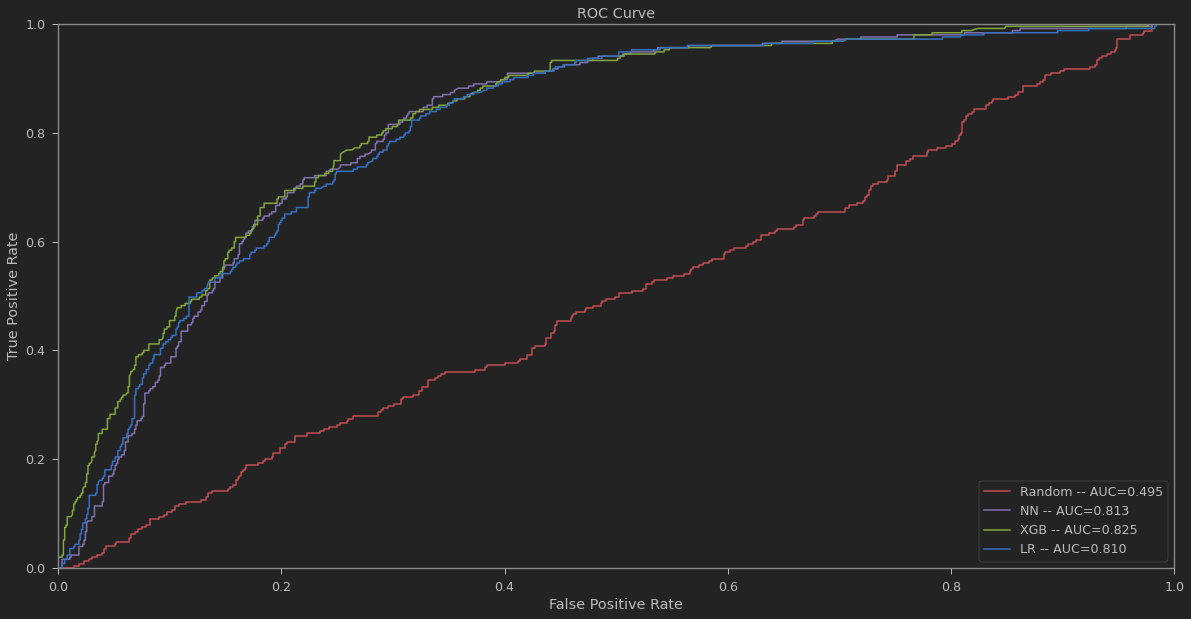

In [104]:
rng = np.random.RandomState(seed=2)
Y_pred_rand = rng.uniform(0,1,Y_test.shape[0]) # Baseline
Y_pred_nn = opt_nn.predict_proba(X_test)[:,1]
Y_pred_xgb = opt_xgb.predict_proba(X_test)[:,1]
Y_pred_lr = opt_logistic.predict_proba(X_test)[:,1]

fig = plt.subplots(1,1,figsize=(20,10))

for preds, c, label in zip([Y_pred_baseline, Y_pred_nn, Y_pred_xgb, Y_pred_lr], ['r','m','g','b'], ['Random', 'NN', 'XGB', 'LR']):
    fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr,tpr,c,label=f'{label} -- AUC={roc_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Because classes are fairly inbalanced, precision recall curves may provide a better metric than ROC curves.

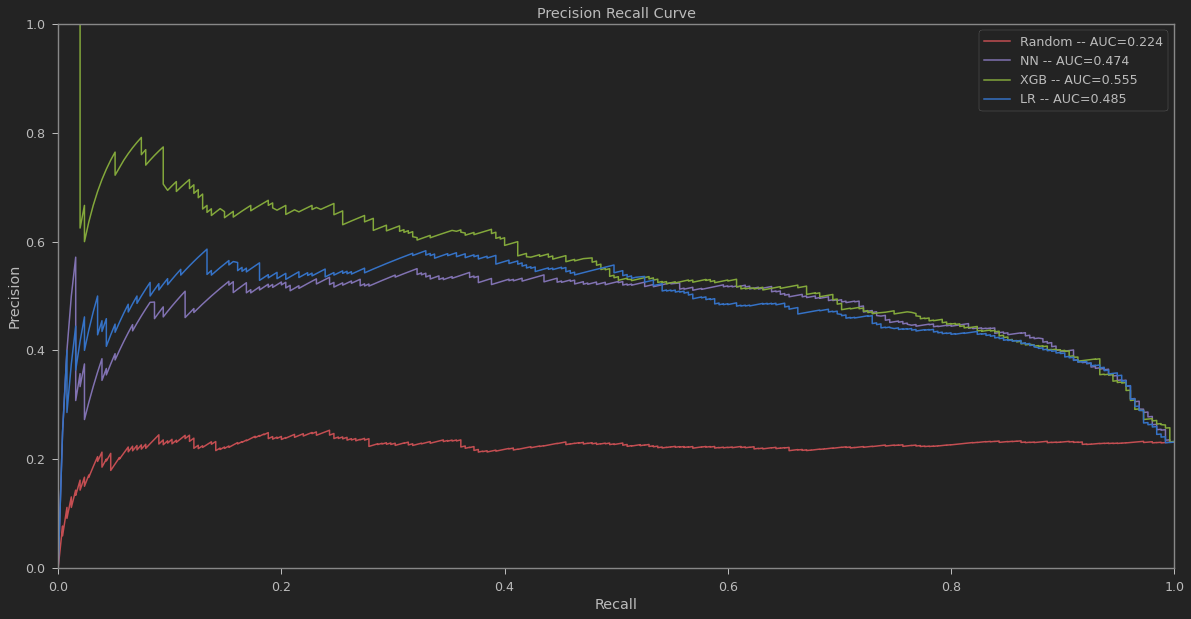

In [90]:
fig = plt.subplots(1,1,figsize=(20,10))

for preds, c, label in zip([Y_pred_baseline, Y_pred_nn, Y_pred_xgb, Y_pred_lr], ['r','m','g','b'], ['Random', 'NN', 'XGB', 'LR']):
    precision, recall, threshold = metrics.precision_recall_curve(Y_test, preds)
    pr_auc = metrics.auc(recall, precision)
    plt.title('Precision Recall Curve')
    plt.plot(recall,precision,c,label=f'{label} -- AUC={pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

We see that the XGBoost algorithm is best according to both metrics. 

At this point, we may require more information to solve the problem. We should determine the relative cost of False Positives / False negtatives so that a threshold may be reached. If, for instance, incentives would be given to users that are likely to churn in order for them to stay on the platform, then:

$\text{Cost of False Postive} = \text{Cost of incentives}$

$\text{Cost of False Negative} = \text{(Expected profit from user)} \times \text{(Probability they would not churn if given incentives)} - \text{Cost of incentives}$

Of course, this requires some estimation. For now, we defer any detailed estimation and simply choose the threshold value that maximizes f1 score.

In [97]:
thresholds = {}
for preds, label in zip([Y_pred_baseline, Y_pred_nn, Y_pred_xgb, Y_pred_lr], ['Random', 'NN', 'XGB', 'LR']):
    precision, recall, threshold = metrics.precision_recall_curve(Y_test, preds)
    f1 = 2 * precision * recall / (precision + recall)
    # NaN where precision + recall = 0. The limit of F1 score around precision = recall = 0 is 0, so we assign 0 F1 score to these models.
    f1[np.where(precision+recall==0)[0]] = 0
    opt_threshold = threshold[np.argmax(f1)]
    preds_labels = preds.copy()
    preds_labels[preds > opt_threshold] = 1
    preds_labels[preds <= opt_threshold] = 0
    logging.info(f"Classifier : {label}")
    logging.info(f"    Threshold : {opt_threshold:.4f}")
    logging.info(f"    F1 Score  : {np.max(f1):.3f}")
    logging.info(f"    Accuracy  : {metrics.accuracy_score(Y_test, preds_labels):.3f} ")
    confusion_matrix = metrics.confusion_matrix(Y_test, preds_labels, normalize='all').ravel()
    logging.info(f"    True Positive Rate: {confusion_matrix[3]:.3f}")
    logging.info(f"    True Negative Rate: {confusion_matrix[0]:.3f}")
    logging.info(f"    False Positive Rate: {confusion_matrix[1]:.3f}")
    logging.info(f"    False Negative Rate: {confusion_matrix[2]:.3f}")

/home/kwl/.pyenv/versions/3.6.8/envs/torch-3.6.8/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
2021-12-16 14:52:07,584 - Classifier : Random
2021-12-16 14:52:07,584 -     Threshold : 0.0159
2021-12-16 14:52:07,585 -     F1 Score  : 0.376
2021-12-16 14:52:07,585 -     Accuracy  : 0.243 
2021-12-16 14:52:07,587 -     True Positive Rate: 0.227
2021-12-16 14:52:07,587 -     True Negative Rate: 0.015
2021-12-16 14:52:07,587 -     False Positive Rate: 0.756
2021-12-16 14:52:07,588 -     False Negative Rate: 0.001
2021-12-16 14:52:07,589 - Classifier : NN
2021-12-16 14:52:07,589 -     Threshold : 0.3269
2021-12-16 14:52:07,590 -     F1 Score  : 0.583
2021-12-16 14:52:07,590 -     Accuracy  : 0.765 
2021-12-16 14:52:07,593 -     True Positive Rate: 0.163
2021-12-16 14:52:07,593 -     True Negative Rate: 0.602
2021-12-16 14:52:07,594 -     False Positive Rate: 0.170
2021-12-16 14:52:07,594 - 

## Analysing most important predictors

We choose to work with the XGB classifier alone here, as it was shown to perform the best in the previous section. We will analyze which features are most important to it's predictions. This should be largely independent of the classifier used.

### Permutation Feature Importance

### SHAP Scores